In [1]:
%load_ext autoreload
%autoreload 2

import torch
import pyro
import numpy as np
from scipy.stats import kendalltau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from bb_opt.src.bayesian_opt import (
    optimize,
    get_model_bnn,
    train_model_bnn,
    partial_train_model_bnn,
    train,
    bnn_predict
)
from bb_opt.src.utils import get_path, save_pyro_model, load_pyro_model
from gpu_utils.utils import gpu_init
from tqdm import tnrange

gpu_id = gpu_init()
print(f"Running on GPU {gpu_id}")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

%matplotlib inline

Running on GPU 0


In [2]:
def jointplot(predicted, true, title: str=""):
    if isinstance(predicted, torch.Tensor):
        predicted = predicted.detach().cpu().numpy()

    if isinstance(true, torch.Tensor):
        true = true.detach().cpu().numpy()
        
    ax = sns.jointplot(predicted, true, s=3, alpha=0.5)
    ax.set_axis_labels('Predicted', 'True')
    ax.ax_marg_x.set_title(title)
    return ax

In [3]:
project = "dna_binding"
dataset = "crx_ref_r1"
batch_size = 1
retrain_every = 1000000
partial_steps = 20

root = "/cluster/nhunt/github/bb_opt/"
data_dir = get_path(root, "data", project, dataset)
inputs = np.load(get_path(data_dir, "inputs.npy"))
labels = np.load(get_path(data_dir, "labels.npy"))
train_inputs, test_inputs, train_labels, test_labels = train_test_split(inputs, labels, test_size=.5, random_state=521)

top_k_percent = 1

In [4]:
n_samples = 10
prior_mean = 0
prior_std = .05

bnn_model, guide = get_model_bnn(inputs.shape[1], batch_size, prior_mean, prior_std, device=device)
optimizer = pyro.optim.Adam({})

# model_name = "../models/crx_1000"
# pyro.get_param_store().load(f"{model_name}.params")
# optimizer.load(f"{model_name}.opt")

pyro.clear_param_store()

n_samples = 10
svi = pyro.infer.SVI(bnn_model, guide, optimizer, pyro.infer.Trace_ELBO(n_samples))

to_torch = lambda array: torch.tensor(array, dtype=torch.float32, device=device)
train_inputs, test_inputs, train_labels, test_labels = list(map(to_torch, [train_inputs, test_inputs, train_labels, test_labels]))

In [5]:
n_inputs = 1

train_inputs = train_inputs[0:n_inputs]
train_labels = train_labels[0:n_inputs]

In [6]:
losses = []
train_corrs = []
test_corrs = []
mses = []
best_train_corrs = []
best_test_corrs = []

In [44]:
for _ in tnrange(400):
    losses += train(svi, 5, train_inputs, train_labels, verbose=False)

    preds = bnn_predict(guide, train_inputs, n_samples=50).mean(axis=0)
    train_corrs.append(kendalltau(preds, train_labels)[0])
    
    if n_inputs == 1:
        mses.append((preds - train_labels.item()) ** 2)

    preds = bnn_predict(guide, test_inputs, n_samples=50).mean(axis=0)
    test_corrs.append(kendalltau(preds, test_labels)[0])
    

#     _, sorted_idx = train_labels.sort(descending=True)
#     n_10_percent = int(len(train_labels) * .1)

#     preds = bnn_predict(guide, train_inputs[sorted_idx][:n_10_percent], n_samples=50).mean(axis=0)
#     best_train_corrs.append(kendalltau(preds, train_labels[sorted_idx][:n_10_percent])[0])

#     _, sorted_idx = test_labels.sort(descending=True)
#     n_10_percent = int(len(test_labels) * .1)

#     preds = bnn_predict(guide, test_inputs[sorted_idx][:n_10_percent], n_samples=50).mean(axis=0)
#     best_test_corrs.append(kendalltau(preds, test_labels[sorted_idx][:n_10_percent])[0])

In [41]:
from IPython.display import Audio, display

url = "https://raw.githubusercontent.com/lepisma/cellbell/master/cellbell/bell.wav"

def play_sound():
    display(Audio(url=url, autoplay=True))

play_sound()

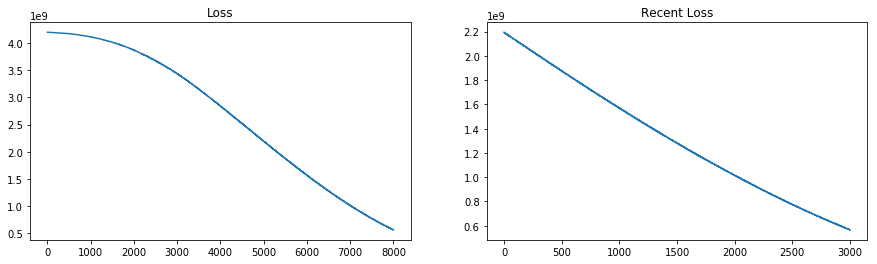

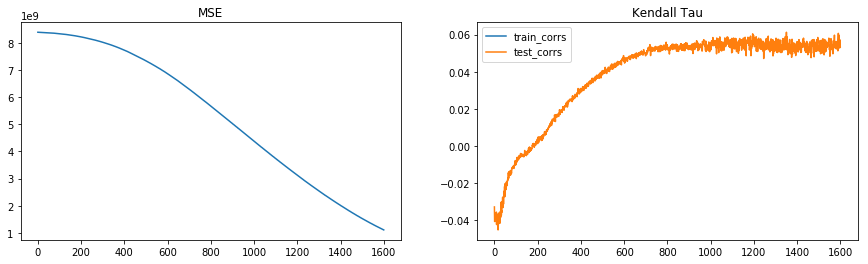

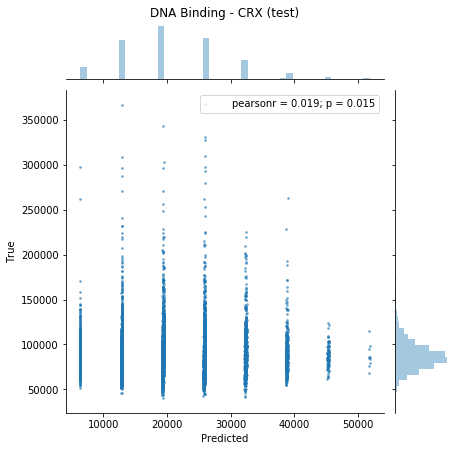

In [43]:
plt.figure(figsize=(15, 4))

plt.subplot(121)
plt.plot(losses)
plt.title("Loss")

plt.subplot(122)
plt.plot(losses[-3000:])
plt.title("Recent Loss")

plt.figure(figsize=(15, 4))

plt.subplot(121)
plt.plot(mses)
plt.title("MSE")

plt.subplot(122)
plt.plot(train_corrs, label="train_corrs")
plt.plot(test_corrs, label="test_corrs")
plt.legend()
plt.title("Kendall Tau");
# plt.plot(pd.Series(losses[-3000:]).rolling(window=100).median());

title = "DNA Binding - CRX"
train_title = title + " (train)"
test_title = title + " (test)"

if n_inputs > 1:
    preds = bnn_predict(guide, train_inputs, n_samples=50).mean(axis=0)
    jointplot([preds], train_labels, train_title)

preds = bnn_predict(guide, test_inputs, n_samples=50).mean(axis=0)
jointplot(preds, test_labels, test_title);

In [51]:
save_pyro_model("tmp_model", optimizer)

In [9]:
ps = pyro.get_param_store()
ps.get_all_param_names()

In [13]:
ps.get_param('g_0.bias_location').grad

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')